In [482]:
import numpy as np
import matplotlib.pylab as pl
import ot
import ot.plot
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from concave_hull import concave_hull, concave_hull_indexes
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.color import label2rgb
from scipy.spatial import distance
import networkx as nx
from scipy.spatial import ConvexHull
import random
from skimage.morphology import skeletonize
from skimage.draw import disk

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


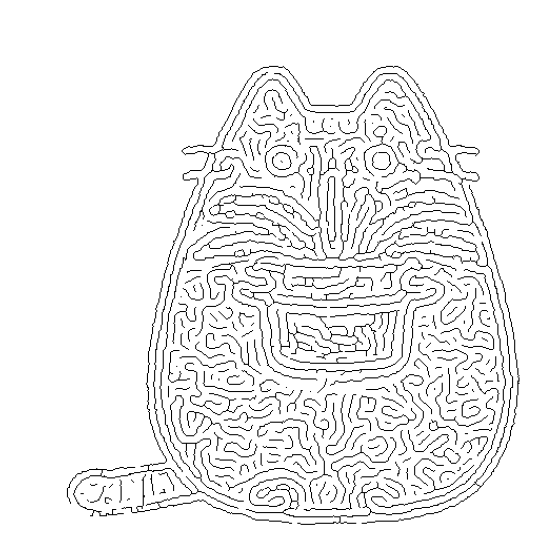

In [483]:
def load_grid(csv_path):
    return pd.read_csv(csv_path, header=None).values

csv_path = 'remaped.csv'
grille_binaire = load_grid(csv_path)


print(grille_binaire)
plt.figure(figsize=(7, 7))
plt.imshow(grille_binaire, cmap='gray')
plt.axis('off')
plt.show()

Ici il faut absolument remplir les trous dans le graph

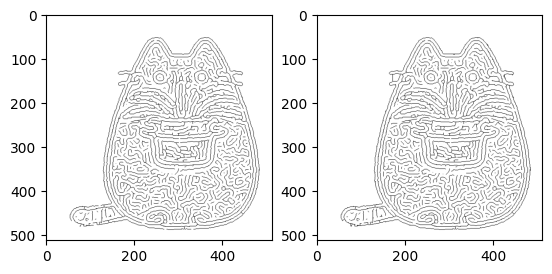

In [484]:
def bresenham(x0, y0, x1, y1):
    """Implementation of Bresenham's line algorithm."""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

grid = grille_binaire

points = np.column_stack(np.where(grid == 0))
convex_hull = ConvexHull(points)

length_threshold = 1
idxes = concave_hull_indexes(points, length_threshold=length_threshold)
assert np.all(points[idxes] == concave_hull(points, length_threshold=length_threshold))

grid_clone = grid.copy()

for f, t in zip(idxes[:-1], idxes[1:]):
    seg = points[[f, t]]
    line_points = bresenham(int(seg[0][0]), int(seg[0][1]), int(seg[1][0]), int(seg[1][1]))
    for x, y in line_points:
        grid_clone[x, y] = 0

# fermeture avec bresenham
if len(idxes) > 0:
    seg = points[[idxes[-1], idxes[0]]]
    line_points = bresenham(int(seg[0][0]), int(seg[0][1]), int(seg[1][0]), int(seg[1][1]))
    for x, y in line_points:
        grid_clone[x, y] = 0


plt.subplot(1, 2, 1)
plt.imshow(grid, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(grid_clone, cmap='gray')

plt.show()

grille_binaire=grid_clone

Les murs sont en noirs ci dessus

In [485]:
def flood_fill_iteratif(grille, x, y, marqueur, marqueurs):
    pile = [(x, y)]
    points = []
    while pile:
        cx, cy = pile.pop()
        if cx < 0 or cx >= grille.shape[0] or cy < 0 or cy >= grille.shape[1]:
            continue
        if grille[cx, cy] != 0 or marqueurs[cx, cy] != 0:
            continue
        marqueurs[cx, cy] = marqueur
        points.append((cx, cy))
        pile.append((cx + 1, cy))
        pile.append((cx - 1, cy))
        pile.append((cx, cy + 1))
        pile.append((cx, cy - 1))
    return points

13


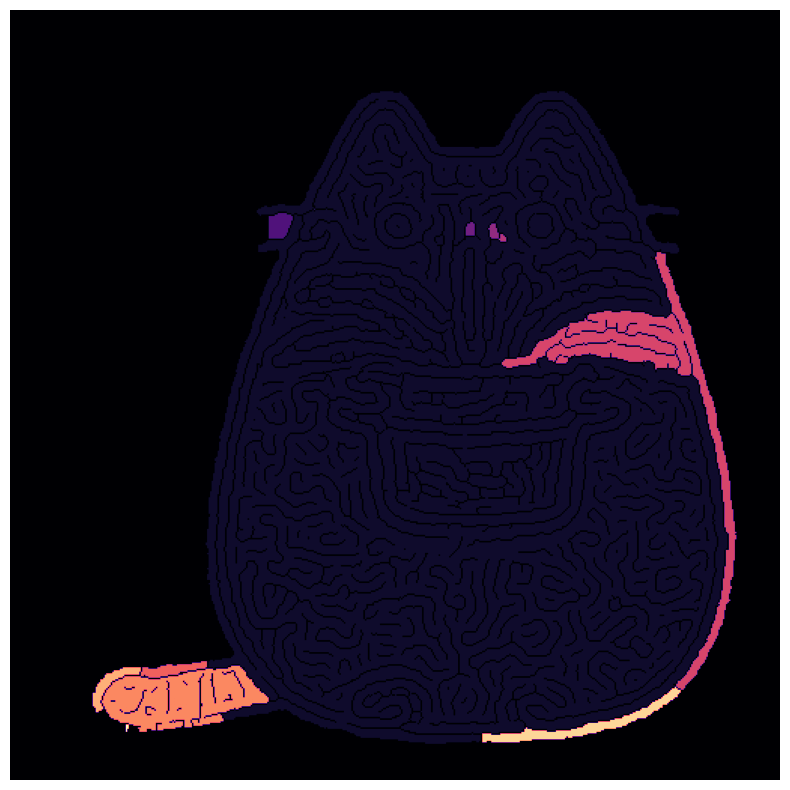

In [486]:
grille_binaire=1-grille_binaire

# Initialiser les marqueurs
marqueurs = np.zeros_like(grille_binaire, dtype=int)
marqueur_actuel = 1
chambres = []

# flood fill itératif pour chaque pixel blanc non marqué
for i in range(grille_binaire.shape[0]):
    for j in range(grille_binaire.shape[1]):
        if grille_binaire[i, j] == 0 and marqueurs[i, j] == 0:
            points = flood_fill_iteratif(grille_binaire, i, j, marqueur_actuel, marqueurs)
            centre = np.mean(points, axis=0)
            chambres.append((marqueur_actuel, centre, points))
            marqueur_actuel += 1





chambres_colorees = np.copy(grille_binaire)
for chambre_id, _, points in chambres:
    for (x, y) in points:
        chambres_colorees[x, y] = chambre_id

print(len(chambres))
plt.figure(figsize=(10, 10))
plt.imshow(chambres_colorees, cmap='magma')
plt.axis('off')
plt.show()

In [487]:
import networkx as nx
import numpy as np
from scipy.spatial import distance, KDTree

G = nx.Graph()

# Noeuds du graph
positions = {}
for chambre_id, centre, _ in chambres:
    positions[chambre_id] = (centre[1], centre[0])
    G.add_node(chambre_id, pos=(centre[1], centre[0]))

# Créer le KD-Tree
centres = [centre for _, centre, _ in chambres]
kdtree = KDTree(centres)

# Ajouter les arêtes + proximité directe des chambres
for i, (id1, centre1, _) in enumerate(chambres):
    distances, indices = kdtree.query(centre1, k=5)  # k=5 to include the node itself
    for dist, idx in zip(distances[1:], indices[1:]):  # Skip the first one as it is the node itself
        id2 = chambres[idx][0]
        G.add_edge(id1, id2, weight=dist)

# D/A
max_dist = 0
start_node, end_node = None, None
for i in range(len(chambres)):
    for j in range(i + 1, len(chambres)):
        dist = distance.euclidean(chambres[i][1], chambres[j][1])
        if dist > max_dist:
            max_dist = dist
            start_node = chambres[i][0]
            end_node = chambres[j][0]

# Calculer le plus court chemin avec Dijkstra
shortest_path = nx.dijkstra_path(G, source=start_node, target=end_node)

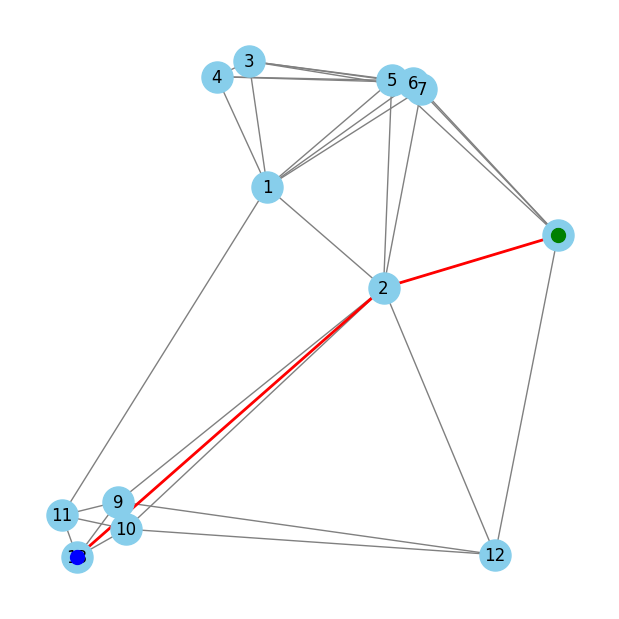

In [488]:
plt.figure(figsize=(6, 6))
nx.draw(G, pos=positions, with_labels=True, node_color='skyblue', node_size=500, edge_color='gray')
path_edges = list(zip(shortest_path, shortest_path[1:]))
nx.draw_networkx_edges(G, pos=positions, edgelist=path_edges, edge_color='red', width=2)


plt.scatter(*positions[start_node], color='green', s=100, zorder=5)
plt.scatter(*positions[end_node], color='blue', s=100, zorder=5)
plt.gca().invert_yaxis() #le graphe est à l'envers
plt.show()

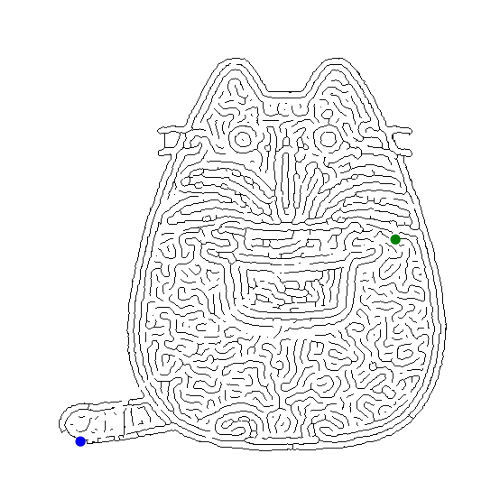

In [489]:
grille=grille_binaire
# Superposer le path
for i in range(len(shortest_path) - 1):
    start = positions[shortest_path[i]]
    end = positions[shortest_path[i + 1]]


    x1, y1 = int(start[1]), int(start[0])
    x2, y2 = int(end[1]), int(end[0])


    rr, cc = np.linspace(x1, x2, num=1000, dtype=int), np.linspace(y1, y2, num=1000, dtype=int)
    for (x, y) in zip(rr, cc):
        rr_disk, cc_disk = disk((x, y), 2)
        for (r, c) in zip(rr_disk, cc_disk):
            if 0 <= r < grille.shape[0] and 0 <= c < grille.shape[1]:
                grille[r, c] = 0




# Marquer D/A
start_pos = positions[start_node]
end_pos = positions[end_node]
rr_start, cc_start = disk((int(start_pos[1]), int(start_pos[0])), 2)
rr_end, cc_end = disk((int(end_pos[1]), int(end_pos[0])), 2)



# final maze display
plt.figure(figsize=(6, 6))
plt.scatter(start_pos[0], start_pos[1], color='green', s=40, zorder=5)
plt.scatter(end_pos[0], end_pos[1], color='blue', s=40, zorder=5)
grille=1-(grille > 0.5).astype(int) #inversion pour les couleurs
plt.imshow(grille, cmap='gray')
plt.axis('off')
plt.show()